In [1]:
# import needed python libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import plotly.offline as py 
import plotly.express as px
import plotly.graph_objs as go # it's like "plt" of matplot

from sklearn.mixture import GaussianMixture
from plotly.subplots import make_subplots
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler



# 1 Data exploration and preprocessing

## 1.1 Dataset Acquisition ###

In [2]:
#### List of Attributes for dataset acquired from german.doc
#### good/bad is the label 1 means good customer while 2 means bad
attributes = ["Status_account", "Duration", "Credit_history","Purpose",
             "Credit_amount","Savings_account_bonds","Employment_since","Install_rate",
              "Personal_status_sex","debtors_guarantors","Present_residence_since",
              "Property","Age","Other_install_plans","Housing","No_credits","Job",
              "No_people_liable","Telephone","foreign_worker","good_bad"] 

#### Acquiring dataset from german.data file
df = pd.read_csv("statlog+german+credit+data/german.data", sep=' ', names = attributes)


### 1.2 Data Preprocessing ###

In [3]:
#### Splitting the data into sets 
columns_no_label = df.columns.drop("good_bad")

X_not_encoded, X_test_not_encoded, y, y_test = train_test_split(
    df[columns_no_label], # X
    df['good_bad'], # y
    stratify = df['good_bad'], # stratify the dataset based on class labels
    train_size = 0.8, # percentage of training set
    random_state = 15 
)

#### Qualitative attributes that do not require encoding 
to_remove = ["Duration","Credit_amount","Install_rate","Present_residence_since",
             "Age","No_credits","No_people_liable","good_bad"] 

#### Creating the list with the categorical attributes to be encoded
to_be_encoded = attributes.copy()
for el in to_remove:
    to_be_encoded.remove(el)

to_remove.remove("good_bad")

#### Using One Hot Encoding to transform categorical attributes into qualitative ones
X_encoded = pd.get_dummies(X_not_encoded, columns=to_be_encoded, dtype = int)
X_test_encoded = pd.get_dummies(X_test_not_encoded, columns=to_be_encoded, dtype = int)

#### Setting bad to 0 and good to 1
mask_bad = y == 2
y = np.where(mask_bad, 0, 1)

mask_bad = y_test == 2
y_test = np.where(mask_bad, 0, 1)

#### Normalization between [0,1]
scaler = MinMaxScaler()

#### Creation of the pandas dataframe of the normalized values
X = scaler.fit_transform(X_encoded)
X_test = scaler.fit_transform(X_test_encoded)
X = pd.DataFrame(X, columns=X_encoded.columns)
X_test = pd.DataFrame(X_test, columns=X_encoded.columns)


### TEST EVALUATING DIFFERENT PCA VALUES

### Classifier Selection
We choose from various classifiers, notably:
- Decision Tree classifier
- Gaussian Naive Bayes classifier
- K-Nearest Neighbors classifier
- Support Vector Machines classifier
- Logistic regressor
- Neural Networks 

## Option 1: You can choose to run the code by yourself but take in consideration that the execution time will be very long

In [ ]:
### Here i'am trying all the possibile "n_components" values starting from 60 down to 15 to see the effective change in the accuracy using:
### Decision Tree
### KNeighborsClassifier
### LogisticRegressor
### GaussianNB
### SVM
values = []
for i in range(60, 15, -1): 
    pca = PCA(n_components = i)
    pca.fit(X)

    print("\n\n***********************")
    content = {}
    print("N_Components: ", i)
    X_PCA = pca.transform(X)
    X_test_PCA = pca.transform(X_test)

    best = 0
    DT_parameters = {"criterion":['gini', 'entropy', 'log_loss'], 'max_depth':[None, 4, 6, 8, 10, 12, 14], 'min_samples_split':[2, 3, 4, 5, 6, 7, 8]}
    GNB_parameters = {"var_smoothing": (np.logspace(-9,0,10))}
    KNN_parameters = {"n_neighbors": range(1,31), "weights": ['uniform','distance'], "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}
    SVM_parameters = {"kernel": ['linear', 'poly', 'rbf', 'sigmoid'], "C": [100, 10, 1.0, 0.1, 0.001]}
    LR_parameters = {"penalty": ['l1', 'l2', 'elasticnet', None], "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], "C": [100, 10, 1.0, 0.1, 0.01], "max_iter": [200]}
    classifiers = [{"classifier": DecisionTreeClassifier, "parameters": DT_parameters}, {"classifier": GaussianNB, "parameters": GNB_parameters},
                   {"classifier": KNeighborsClassifier, "parameters": KNN_parameters}, {"classifier": svm.SVC, "parameters": SVM_parameters}, 
                   {"classifier": LogisticRegression, "parameters": LR_parameters}]
    
    for classifier in classifiers:
        clf = GridSearchCV(classifier["classifier"](), classifier["parameters"], cv = 20, scoring = 'accuracy', n_jobs=10)
        clf.fit(X_PCA, y)
        if (clf.best_score_ > best):
            best = clf.best_score_
            best_clf = clf
            best_clf_name = classifier["classifier"]
            best_clf_score = clf.best_score_
        print("Best Score for " + str(classifier["classifier"]()).replace("()","") + ":", clf.best_score_,"\n")
        content.update({str(classifier["classifier"]()).replace("()",""): clf.best_score_}) 
    
    print("\nBest Classifier: " + str(best_clf_name()).replace("()",""))
    print("Best Score: ", best_clf_score)

    values.append(content)
    print(values)

In [ ]:
data = []
for dict in values:
    for classifier, score in dict.items():
        data.append({"classifier": classifier, "score": float(score)})

In [ ]:
classifier_scores = {classifier: [] for item in data for classifier in (item['classifier'],)}
for item in data:
    classifier_scores[item['classifier']].append(item['score'])
    
classifiers_pca = classifier_scores.keys()

### Make the plot of different classifiers according to the number of components
plt.figure(figsize=(12, 10))

for classifier in classifiers_pca:
    plt.plot(classifier_scores[classifier][::-1], marker='o',  label=classifier)
    
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Accuracy ')
plt.tick_params(bottom=True, labelbottom=True)  # Ensure x-axis labels are displayed
plt.xticks(range(len(classifier_scores[classifier])), range(15, len(classifier_scores[classifier]) + 15))
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.title("Scores for Different Classifiers by Number of Principal Components")
plt.show()

## Option 2: We executed the code and put all the data in an array, then automatically transformed in the needed way

In [4]:
import re
string = "***********************\
N_Components:  60\
Best Score for DecisionTreeClassifier: 0.7024999999999999 \
Best Score for GaussianNB: 0.7275 \
Best Score for KNeighborsClassifier: 0.74375 \
Best Score for SVC: 0.7625000000000001 \
Best Score for LogisticRegression: 0.76 \
Best Classifier: SVC\
Best Score:  0.7625000000000001\
***********************\
N_Components:  59\
Best Score for DecisionTreeClassifier: 0.7037500000000001 \
Best Score for GaussianNB: 0.7275 \
Best Score for KNeighborsClassifier: 0.74375 \
Best Score for SVC: 0.7625000000000001 \
Best Score for LogisticRegression: 0.76 \
Best Classifier: SVC\
Best Score:  0.7625000000000001\
***********************\
N_Components:  58\
Best Score for DecisionTreeClassifier: 0.70625 \
Best Score for GaussianNB: 0.7275 \
Best Score for KNeighborsClassifier: 0.74375 \
Best Score for SVC: 0.7625000000000001 \
Best Score for LogisticRegression: 0.76 \
Best Classifier: SVC\
Best Score:  0.7625000000000001\
***********************\
N_Components:  57\
Best Score for DecisionTreeClassifier: 0.7062499999999999 \
Best Score for GaussianNB: 0.7275 \
Best Score for KNeighborsClassifier: 0.74375 \
Best Score for SVC: 0.7625000000000001 \
Best Score for LogisticRegression: 0.76 \
Best Classifier: SVC\
Best Score:  0.7625000000000001\
***********************\
N_Components:  56\
Best Score for DecisionTreeClassifier: 0.70875 \
Best Score for GaussianNB: 0.7275 \
Best Score for KNeighborsClassifier: 0.74375 \
Best Score for SVC: 0.7625000000000001 \
Best Score for LogisticRegression: 0.76 \
Best Classifier: SVC\
Best Score:  0.7625000000000001\
***********************\
N_Components:  55\
Best Score for DecisionTreeClassifier: 0.7050000000000001 \
Best Score for GaussianNB: 0.7275 \
Best Score for KNeighborsClassifier: 0.74375 \
Best Score for SVC: 0.7625000000000001 \
Best Score for LogisticRegression: 0.76 \
Best Classifier: SVC\
Best Score:  0.7625000000000001\
***********************\
N_Components:  54\
Best Score for DecisionTreeClassifier: 0.70375 \
Best Score for GaussianNB: 0.7275 \
Best Score for KNeighborsClassifier: 0.74375 \
Best Score for SVC: 0.7625000000000001 \
Best Score for LogisticRegression: 0.76 \
Best Classifier: SVC\
Best Score:  0.7625000000000001\
***********************\
N_Components:  53\
Best Score for DecisionTreeClassifier: 0.7012500000000002 \
Best Score for GaussianNB: 0.7275 \
Best Score for KNeighborsClassifier: 0.74375 \
Best Score for SVC: 0.7625000000000001 \
Best Score for LogisticRegression: 0.76 \
Best Classifier: SVC\
Best Score:  0.7625000000000001\
***********************\
N_Components:  52\
Best Score for DecisionTreeClassifier: 0.7037500000000001 \
Best Score for GaussianNB: 0.7275 \
Best Score for KNeighborsClassifier: 0.74375 \
Best Score for SVC: 0.7625000000000001 \
Best Score for LogisticRegression: 0.76 \
Best Classifier: SVC\
Best Score:  0.7625000000000001\
***********************\
N_Components:  51\
Best Score for DecisionTreeClassifier: 0.7075 \
Best Score for GaussianNB: 0.7275 \
Best Score for KNeighborsClassifier: 0.74375 \
Best Score for SVC: 0.7625000000000001 \
Best Score for LogisticRegression: 0.76 \
Best Classifier: SVC\
Best Score:  0.7625000000000001\
***********************\
N_Components:  50\
Best Score for DecisionTreeClassifier: 0.7000000000000001 \
Best Score for GaussianNB: 0.7275 \
Best Score for KNeighborsClassifier: 0.74375 \
Best Score for SVC: 0.7625000000000001 \
Best Score for LogisticRegression: 0.76 \
Best Classifier: SVC\
Best Score:  0.7625000000000001\
***********************\
N_Components:  49\
Best Score for DecisionTreeClassifier: 0.7037500000000001 \
Best Score for GaussianNB: 0.7275 \
Best Score for KNeighborsClassifier: 0.74375 \
Best Score for SVC: 0.7625000000000001 \
Best Score for LogisticRegression: 0.76 \
Best Classifier: SVC\
Best Score:  0.7625000000000001\
***********************\
N_Components:  48\
Best Score for DecisionTreeClassifier: 0.7025000000000001 \
Best Score for GaussianNB: 0.7275 \
Best Score for KNeighborsClassifier: 0.74375 \
Best Score for SVC: 0.7625000000000001 \
Best Score for LogisticRegression: 0.76 \
Best Classifier: SVC\
Best Score:  0.7625000000000001\
***********************\
N_Components:  47\
Best Score for DecisionTreeClassifier: 0.7075 \
Best Score for GaussianNB: 0.7262500000000001 \
Best Score for KNeighborsClassifier: 0.7462500000000001 \
Best Score for SVC: 0.7625 \
Best Score for LogisticRegression: 0.7612499999999999 \
Best Classifier: SVC\
Best Score:  0.7625\
***********************\
N_Components:  46\
Best Score for DecisionTreeClassifier: 0.7050000000000001 \
Best Score for GaussianNB: 0.72875 \
Best Score for KNeighborsClassifier: 0.7449999999999999 \
Best Score for SVC: 0.76375 \
Best Score for LogisticRegression: 0.7612499999999999 \
Best Classifier: SVC\
Best Score:  0.76375\
***********************\
N_Components:  45\
Best Score for DecisionTreeClassifier: 0.70125 \
Best Score for GaussianNB: 0.72875 \
Best Score for KNeighborsClassifier: 0.7424999999999999 \
Best Score for SVC: 0.7625000000000001 \
Best Score for LogisticRegression: 0.7637499999999999 \
Best Classifier: LogisticRegression\
Best Score:  0.7637499999999999\
***********************\
N_Components:  44\
Best Score for DecisionTreeClassifier: 0.7037500000000001 \
Best Score for GaussianNB: 0.725 \
Best Score for KNeighborsClassifier: 0.745 \
Best Score for SVC: 0.765 \
Best Score for LogisticRegression: 0.7649999999999999 \
Best Classifier: SVC\
Best Score:  0.765\
***********************\
N_Components:  43\
Best Score for DecisionTreeClassifier: 0.7037500000000001 \
Best Score for GaussianNB: 0.72875 \
Best Score for KNeighborsClassifier: 0.7424999999999999 \
Best Score for SVC: 0.76375 \
Best Score for LogisticRegression: 0.7612499999999999 \
Best Classifier: SVC\
Best Score:  0.76375\
***********************\
N_Components:  42\
Best Score for DecisionTreeClassifier: 0.6987500000000001 \
Best Score for GaussianNB: 0.7275 \
Best Score for KNeighborsClassifier: 0.73875 \
Best Score for SVC: 0.76 \
Best Score for LogisticRegression: 0.7550000000000001 \
Best Classifier: SVC\
Best Score:  0.76\
***********************\
N_Components:  41\
Best Score for DecisionTreeClassifier: 0.7012500000000002 \
Best Score for GaussianNB: 0.72875 \
Best Score for KNeighborsClassifier: 0.7425 \
Best Score for SVC: 0.76125 \
Best Score for LogisticRegression: 0.75625 \
Best Classifier: SVC\
Best Score:  0.76125\
***********************\
N_Components:  40\
Best Score for DecisionTreeClassifier: 0.7000000000000001 \
Best Score for GaussianNB: 0.72875 \
Best Score for KNeighborsClassifier: 0.7412500000000001 \
Best Score for SVC: 0.7625000000000001 \
Best Score for LogisticRegression: 0.75875 \
Best Classifier: SVC\
Best Score:  0.7625000000000001\
***********************\
N_Components:  39\
Best Score for DecisionTreeClassifier: 0.6987500000000001 \
Best Score for GaussianNB: 0.73125 \
Best Score for KNeighborsClassifier: 0.7462500000000001 \
Best Score for SVC: 0.7625000000000001 \
Best Score for LogisticRegression: 0.75625 \
Best Classifier: SVC\
Best Score:  0.7625000000000001\
***********************\
N_Components:  38\
Best Score for DecisionTreeClassifier: 0.6950000000000001 \
Best Score for GaussianNB: 0.7337499999999999 \
Best Score for KNeighborsClassifier: 0.7525000000000001 \
Best Score for SVC: 0.7625000000000001 \
Best Score for LogisticRegression: 0.75125 \
Best Classifier: SVC\
Best Score:  0.7625000000000001\
***********************\
N_Components:  37\
Best Score for DecisionTreeClassifier: 0.6975 \
Best Score for GaussianNB: 0.7324999999999999 \
Best Score for KNeighborsClassifier: 0.75125 \
Best Score for SVC: 0.76375 \
Best Score for LogisticRegression: 0.75 \
Best Classifier: SVC\
Best Score:  0.76375\
***********************\
N_Components:  36\
Best Score for DecisionTreeClassifier: 0.70625 \
Best Score for GaussianNB: 0.7325 \
Best Score for KNeighborsClassifier: 0.74 \
Best Score for SVC: 0.755 \
Best Score for LogisticRegression: 0.7424999999999999 \
Best Classifier: SVC\
Best Score:  0.755\
***********************\
N_Components:  35\
Best Score for DecisionTreeClassifier: 0.705 \
Best Score for GaussianNB: 0.73875 \
Best Score for KNeighborsClassifier: 0.7375 \
Best Score for SVC: 0.75625 \
Best Score for LogisticRegression: 0.745 \
Best Classifier: SVC\
Best Score:  0.75625\
***********************\
N_Components:  34\
Best Score for DecisionTreeClassifier: 0.705 \
Best Score for GaussianNB: 0.735 \
Best Score for KNeighborsClassifier: 0.7400000000000001 \
Best Score for SVC: 0.7550000000000001 \
Best Score for LogisticRegression: 0.745 \
Best Classifier: SVC\
Best Score:  0.7550000000000001\
***********************\
N_Components:  33\
Best Score for DecisionTreeClassifier: 0.7 \
Best Score for GaussianNB: 0.7337499999999999 \
Best Score for KNeighborsClassifier: 0.74 \
Best Score for SVC: 0.7575000000000001 \
Best Score for LogisticRegression: 0.74625 \
Best Classifier: SVC\
Best Score:  0.7575000000000001\
***********************\
N_Components:  32\
Best Score for DecisionTreeClassifier: 0.70375 \
Best Score for GaussianNB: 0.73875 \
Best Score for KNeighborsClassifier: 0.7425 \
Best Score for SVC: 0.75375 \
Best Score for LogisticRegression: 0.7424999999999999 \
Best Classifier: SVC\
Best Score:  0.75375\
***********************\
N_Components:  31\
Best Score for DecisionTreeClassifier: 0.7049999999999998 \
Best Score for GaussianNB: 0.7424999999999999 \
Best Score for KNeighborsClassifier: 0.7462500000000001 \
Best Score for SVC: 0.7550000000000001 \
Best Score for LogisticRegression: 0.7425 \
Best Classifier: SVC\
Best Score:  0.7550000000000001\
***********************\
N_Components:  30\
Best Score for DecisionTreeClassifier: 0.695 \
Best Score for GaussianNB: 0.7425 \
Best Score for KNeighborsClassifier: 0.7450000000000001 \
Best Score for SVC: 0.7537499999999999 \
Best Score for LogisticRegression: 0.745 \
Best Classifier: SVC\
Best Score:  0.7537499999999999\
***********************\
N_Components:  29\
Best Score for DecisionTreeClassifier: 0.7025 \
Best Score for GaussianNB: 0.745 \
Best Score for KNeighborsClassifier: 0.7437499999999999 \
Best Score for SVC: 0.745 \
Best Score for LogisticRegression: 0.74625 \
Best Classifier: LogisticRegression\
Best Score:  0.74625\
***********************\
N_Components:  28\
Best Score for DecisionTreeClassifier: 0.67875 \
Best Score for GaussianNB: 0.745 \
Best Score for KNeighborsClassifier: 0.7400000000000001 \
Best Score for SVC: 0.74875 \
Best Score for LogisticRegression: 0.7474999999999999 \
Best Classifier: SVC\
Best Score:  0.74875\
***********************\
N_Components:  27\
Best Score for DecisionTreeClassifier: 0.69 \
Best Score for GaussianNB: 0.7412500000000001 \
Best Score for KNeighborsClassifier: 0.7462500000000001 \
Best Score for SVC: 0.74875 \
Best Score for LogisticRegression: 0.75125 \
Best Classifier: LogisticRegression\
Best Score:  0.75125\
***********************\
N_Components:  26\
Best Score for DecisionTreeClassifier: 0.68875 \
Best Score for GaussianNB: 0.73875 \
Best Score for KNeighborsClassifier: 0.7300000000000001 \
Best Score for SVC: 0.7375 \
Best Score for LogisticRegression: 0.7412500000000001 \
Best Classifier: LogisticRegression\
Best Score:  0.7412500000000001\
***********************\
N_Components:  25\
Best Score for DecisionTreeClassifier: 0.6812500000000001 \
Best Score for GaussianNB: 0.7437500000000001 \
Best Score for KNeighborsClassifier: 0.7325 \
Best Score for SVC: 0.74125 \
Best Score for LogisticRegression: 0.7412500000000001 \
Best Classifier: GaussianNB\
Best Score:  0.7437500000000001\
***********************\
N_Components:  24\
Best Score for DecisionTreeClassifier: 0.6937500000000001 \
Best Score for GaussianNB: 0.74125 \
Best Score for KNeighborsClassifier: 0.7325 \
Best Score for SVC: 0.74375 \
Best Score for LogisticRegression: 0.7425 \
Best Classifier: SVC\
Best Score:  0.74375\
***********************\
N_Components:  23\
Best Score for DecisionTreeClassifier: 0.6900000000000001 \
Best Score for GaussianNB: 0.74 \
Best Score for KNeighborsClassifier: 0.7437500000000001 \
Best Score for SVC: 0.7425 \
Best Score for LogisticRegression: 0.7437500000000001 \
Best Classifier: KNeighborsClassifier\
Best Score:  0.7437500000000001\
***********************\
N_Components:  22\
Best Score for DecisionTreeClassifier: 0.6799999999999999 \
Best Score for GaussianNB: 0.725 \
Best Score for KNeighborsClassifier: 0.72875 \
Best Score for SVC: 0.7350000000000001 \
Best Score for LogisticRegression: 0.7412500000000001 \
Best Classifier: LogisticRegression\
Best Score:  0.7412500000000001\
***********************\
N_Components:  21\
Best Score for DecisionTreeClassifier: 0.6824999999999999 \
Best Score for GaussianNB: 0.7262500000000001 \
Best Score for KNeighborsClassifier: 0.73125 \
Best Score for SVC: 0.7387499999999999 \
Best Score for LogisticRegression: 0.7437499999999999 \
Best Classifier: LogisticRegression\
Best Score:  0.7437499999999999\
***********************\
N_Components:  20\
Best Score for DecisionTreeClassifier: 0.6825 \
Best Score for GaussianNB: 0.7262499999999998 \
Best Score for KNeighborsClassifier: 0.7387499999999998 \
Best Score for SVC: 0.74125 \
Best Score for LogisticRegression: 0.7437499999999999 \
Best Classifier: LogisticRegression\
Best Score:  0.7437499999999999\
***********************\
N_Components:  19\
Best Score for DecisionTreeClassifier: 0.67375 \
Best Score for GaussianNB: 0.73125 \
Best Score for KNeighborsClassifier: 0.735 \
Best Score for SVC: 0.7362499999999998 \
Best Score for LogisticRegression: 0.745 \
Best Classifier: LogisticRegression\
Best Score:  0.745\
***********************\
N_Components:  18\
Best Score for DecisionTreeClassifier: 0.68875 \
Best Score for GaussianNB: 0.7325 \
Best Score for KNeighborsClassifier: 0.7375 \
Best Score for SVC: 0.7275 \
Best Score for LogisticRegression: 0.745 \
Best Classifier: LogisticRegression\
Best Score:  0.745\
***********************\
N_Components:  17\
Best Score for DecisionTreeClassifier: 0.68875 \
Best Score for GaussianNB: 0.715 \
Best Score for KNeighborsClassifier: 0.72875 \
Best Score for SVC: 0.72625 \
Best Score for LogisticRegression: 0.72875 \
Best Classifier: KNeighborsClassifier\
Best Score:  0.72875\
***********************\
N_Components:  16\
Best Score for DecisionTreeClassifier: 0.6825000000000001 \
Best Score for GaussianNB: 0.7162499999999999 \
Best Score for KNeighborsClassifier: 0.715 \
Best Score for SVC: 0.7149999999999999 \
Best Score for LogisticRegression: 0.72875 \
Best Classifier: LogisticRegression\
Best Score:  0.72875"

data =[]
score_pattern = r"Best Score for (?P<classifier>\w+):\s+(?P<score>0\.\d+)"
for row in string:
    matches = re.findall(score_pattern,string)

for match in matches:
    classifier, score = match
    data.append({"classifier": classifier, "score": float(score)})

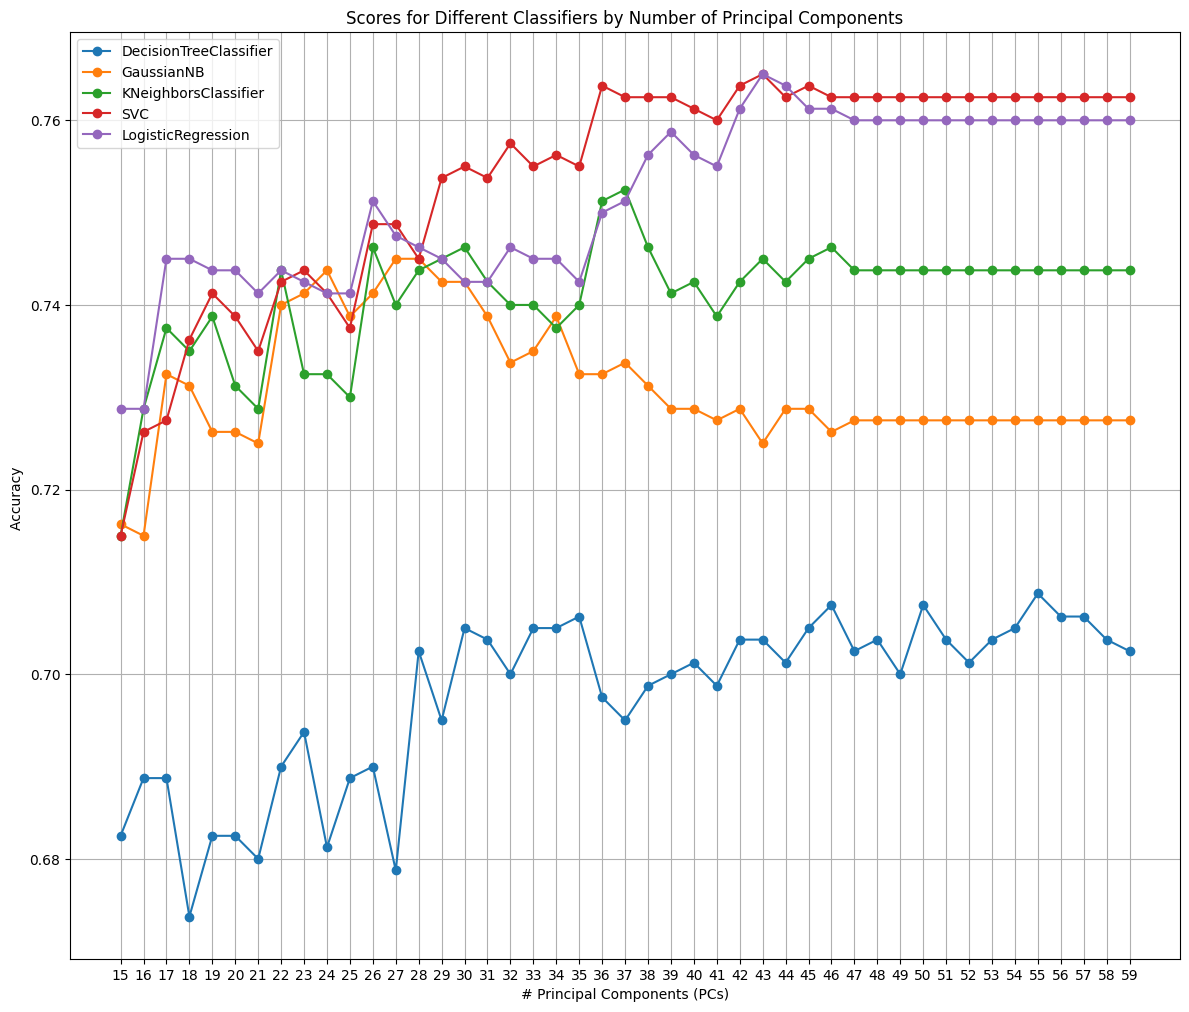

In [5]:
classifier_scores = {classifier: [] for item in data for classifier in (item['classifier'],)}
for item in data:
    classifier_scores[item['classifier']].append(item['score'])
    
classifiers_pca = classifier_scores.keys()

### Make the plot of different classifiers according to the number of components
plt.figure(figsize=(12, 10))

for classifier in classifiers_pca:
    plt.plot(classifier_scores[classifier][::-1], marker='o',  label=classifier)
    
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Accuracy ')
plt.tick_params(bottom=True, labelbottom=True)  # Ensure x-axis labels are displayed
plt.xticks(range(len(classifier_scores[classifier])), range(15, len(classifier_scores[classifier]) + 15))
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.title("Scores for Different Classifiers by Number of Principal Components")
plt.show()
